Membuat model terbaik dengan filtrasi citra ResNet dengan Teknik Ensemble

In [ ]:
# Mount dataset dari kaggle
from google.colab import files # Mengimpor modul untuk meng-upload file di Google Colab.
uploaded = files.upload() # Memungkinkan pengguna untuk meng-upload file
!mkdir -p ~/.kaggle # Membuat direktori
!mv kaggle.json ~/.kaggle/ # Memindahkan file kaggle.json ke direktori .kaggle
!chmod 600 ~/.kaggle/kaggle.json # Mengatur izin file agar hanya dapat dibaca oleh pemilik.
!kaggle datasets download -d gunavenkatdoddi/eye-diseases-classification ## berisi API Kaggle yang digunakan
!unzip -q eye-diseases-classification.zip # Mengekstrak file zip dataset yang diunduh

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/gunavenkatdoddi/eye-diseases-classification
License(s): ODbL-1.0
 99% 730M/736M [00:11<00:00, 96.9MB/s]
100% 736M/736M [00:11<00:00, 66.2MB/s]


In [ ]:
# Import Libraries
import numpy as np # Untuk operasi numerik
import os # Untuk interaksi dengan sistem file
import matplotlib.pyplot as plt # Untuk visualisasi data
from tensorflow.keras.applications import ResNet50 #Untuk membangun dan menggunakan model deep learning
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc #Untuk model evaluasi
import seaborn as sns # Untuk visualisasi data yang lebih baik
from tqdm import tqdm # Untuk menampilkan progress bar saat memproses data
import gc # Untuk pengelolaan memori

In [ ]:
# Setup Directories and Parameters
data_dir = '/content/dataset'  # Menentukan direktori tempat dataset disimpan
categories = ['normal', 'cataract', 'glaucoma', 'diabetic_retinopathy'] # Daftar kategori penyakit mata yang ada dalam dataset
img_size = 224  # Ukuran gambar yang akan digunakan untuk model ResNet50 (224x224 piksel)

In [ ]:
# Define Data Loader Function
def load_images_and_labels(data_dir, categories, img_size): # Fungsi untuk memuat gambar dan label dari direktori
    images = [] # List untuk menyimpan gambar
    labels = [] # List untuk menyimpan label
    for idx, category in enumerate(categories): # Mengiterasi kategori dan mendapatkan indeksnya
        class_folder = os.path.join(data_dir, category) # Menggabungkan path direktori dataset dengan nama kategori
        for img_file in tqdm(os.listdir(class_folder)): # Fungsi menampikan progress bar saat membuat gambar pada file kategori
            img_path = os.path.join(class_folder, img_file)
            img = load_img(img_path, target_size=(img_size, img_size)) #Memuat gambar dari path yang diberikan dan mengubah ukurannya menjadi 224x224 piksel
            img = img_to_array(img) #Mengonversi gambar yang dimuat menjadi array NumPy
            # Fungsi preprocess_input dari tensorflow.keras.applications.resnet50 melakukan normalisasi pada gambar dengan mengubah rentang nilai piksel dari [0, 255] menjadi [-1, 1], serta memastikan format dan dimensi gambar sesuai dengan yang diharapkan oleh model ResNet50
            img = preprocess_input(img)  # Melakukan preprocessing pada gambar sesuai dengan yang diperlukan oleh model ResNet50 (normalisasi)
            images.append(img) # Menambahkan gambar yang telah diproses ke dalam list
            labels.append(idx) # Mengembalikan array NumPy dari gambar dan label
    return np.array(images), np.array(labels)


Fungsi preprocess_input dari tensorflow.keras.applications.resnet50 adalah fungsi khusus yang melakukan preprocessing pada gambar sebelum gambar tersebut dimasukkan ke dalam model ResNet50. Preprocessing ini dirancang untuk menyesuaikan data gambar dengan kondisi yang sama saat model ResNet50 dilatih pada dataset ImageNet. Berikut adalah langkah-langkah preprocessing yang dilakukan oleh preprocess_input:

1. Mengubah Skala Warna Piksel: Fungsi preprocess_input akan mengonversi gambar dari skala nilai piksel asli (biasanya 0 hingga 255 untuk setiap kanal warna) ke rentang nilai yang sesuai untuk model ResNet50. Pada ResNet50, preprocessing ini mengubah skala piksel agar sesuai dengan standar tertentu:

  - Pada kasus ResNet50, nilai piksel yang semula 0–255 diubah menjadi rentang antara -1 dan 1. Hal ini dilakukan dengan cara mengurangi rata-rata piksel dari setiap kanal (merah, hijau, dan biru) dan menormalisasi nilainya.

2. Normalisasi Berdasarkan Rata-Rata dari Dataset ImageNet: Model ResNet50 dilatih pada dataset ImageNet yang memiliki karakteristik rata-rata warna tertentu. Fungsi preprocess_input akan mengurangi rata-rata kanal RGB dari dataset ImageNet agar gambar yang dimasukkan ke dalam model memiliki distribusi warna yang mirip dengan data saat model dilatih.

3. Penskalaan Nilai Piksel (Scaling): Setelah dikurangi dengan nilai rata-rata kanal, nilai piksel yang dihasilkan berada dalam rentang tertentu. Beberapa versi dari preprocess_input juga akan menormalkan piksel sehingga berada dalam rentang -1 hingga 1 atau 0 hingga 1, tergantung dari model dan konfigurasi tertentu. Untuk ResNet50, biasanya piksel berada dalam rentang -1 hingga 1 setelah preprocess.

4. Konsistensi Warna Gambar: Fungsi preprocess_input juga memastikan bahwa input ke dalam model konsisten dalam hal intensitas warna, yang membantu model dalam memahami informasi gambar dengan lebih baik. Gambar yang terlalu cerah atau terlalu gelap bisa menyebabkan model gagal mengenali fitur penting, sehingga normalisasi warna ini sangat berguna.

In [ ]:
# Load and split dataset
images, labels = load_images_and_labels(data_dir, categories, img_size) # Memanggil fungsi untuk memuat gambar dan label dari dataset
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels) # Membagi dataset menjadi data pelatihan (80%) dan data pengujian (20%). Parameter stratify=labels memastikan bahwa proporsi label di data pelatihan dan pengujian tetap sama.

100%|██████████| 1098/1098 [00:02<00:00, 423.42it/s]


In [ ]:
# Define ResNet50 for feature extraction
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3)) # Memuat model ResNet50 yang telah dilatih pada dataset ImageNet, tanpa lapisan klasifikasi di atasnya (include_top=False).
x = base_model.output # Mengambil output dari model dasar (ResNet50)
x = GlobalAveragePooling2D()(x) # Menambahkan lapisan pooling rata-rata global untuk mengurangi dimensi output dari model
model = Model(inputs=base_model.input, outputs=x) # Membuat model baru yang menghubungkan input dari ResNet50 dengan output dari lapisan pooling

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Extract features
def extract_features(data, model): # Fungsi untuk mengekstrak fitur
    features = model.predict(data, batch_size=16) # Menggunakan model untuk memprediksi fitur dari data yang diberikan, dengan ukuran batch 16
    return features

X_train_features = extract_features(X_train, model) # Mengekstrak fitur dari data pelatihan
X_test_features = extract_features(X_test, model) # Mengekstrak fitur dari data pengujian

211/211 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step


In [ ]:
# Sebelum PCA
print("Dimensi sebelum PCA:", X_train_features.shape)

Dimensi sebelum PCA: (3373, 2048)


In [ ]:
# PCA for dimensionality reduction
pca = PCA(n_components=400) # membuat objek PCA untuk mengurangi dimensi fitur menjadi 100 komponen utama
X_train_pca = pca.fit_transform(X_train_features) # Menghitung PCA pada fitur pelatihan dan mengubah fitur pelatihan menjadi representasi dengan dimensi yang lebih rendah
X_test_pca = pca.transform(X_test_features) # Mengubah fitur pengujian menggunakan transformasi PCA yang sama yang diterapkan pada data pelatihan

In [ ]:
# Setelah PCA
print("Dimensi setelah PCA:", X_train_pca.shape)

Dimensi setelah PCA: (3373, 400)


In [ ]:
# Initialize models
rf = RandomForestClassifier() # Menginisialisasi model Random Forest untuk klasifikasi
svm = SVC(probability=True) # Menginisialisasi model Support Vector Classifier (SVC) dengan opsi probability=True untuk memungkinkan prediksi probabilitas
xgb = XGBClassifier(eval_metric='mlogloss') # Menginisialisasi model XGBoost untuk klasifikasi dengan metrik evaluasi mlogloss.

# Parameter grids
param_rf = {'n_estimators': [100, 200], 'max_depth': [10, 20]} # Mendefinisikan grid parameter untuk model Random Forest, termasuk jumlah estimator dan kedalaman maksimum
param_svm = {'C': [1, 10], 'gamma': ['scale', 'auto']} # Mendefinisikan grid parameter untuk model SVC, termasuk parameter C dan gamma
param_xgb = {'max_depth': [5, 10], 'n_estimators': [100, 200]} # Mendefinisikan grid parameter untuk model XGBoost, termasuk kedalaman maksimum dan jumlah estimator

# Adjust n_iter to match parameter grid size. RandomizedSearchCV untuk menemukan kombinasi parameter terbaik
# n_iter=4: Menentukan jumlah kombinasi parameter yang akan diuji. cv=3: Menggunakan 3-fold cross-validation untuk evaluasi model. random_state=42: Menetapkan seed untuk reproduktifitas.
rf_random = RandomizedSearchCV(rf, param_rf, n_iter=4, cv=3, random_state=42)
svm_random = RandomizedSearchCV(svm, param_svm, n_iter=4, cv=3, random_state=42)
xgb_random = RandomizedSearchCV(xgb, param_xgb, n_iter=4, cv=3, random_state=42)

# Melatih model dengan data pelatihan yang telah direduksi dimensinya
rf_random.fit(X_train_pca, y_train)
svm_random.fit(X_train_pca, y_train)
xgb_random.fit(X_train_pca, y_train)

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='mlogloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learnin...=None,
                                           max_cat_threshold=None,
                                           max_cat_to_onehot=None,
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_iter=4,
                   param_distributions={'max_depth': [5, 10],
                                        'n_estimators': [100, 200]},
                   random_state=42)

In [ ]:
# Ensemble Learning
# estimators=[...]: Menyediakan daftar model yang akan digabungkan. voting='soft': Menggunakan voting berbasis probabilitas (soft voting) untuk prediksi. ensemble.fit(X_train_pca, y_train): Melatih model ensemble dengan data pelatihan yang telah direduksi dan label pelatihan
ensemble = VotingClassifier(estimators=[('rf', rf_random.best_estimator_), ('svm', svm_random.best_estimator_), ('xgb', xgb_random.best_estimator_)], voting='soft')
ensemble.fit(X_train_pca, y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=20,
                                                     n_estimators=200)),
                             ('svm', SVC(C=10, gamma='auto', probability=True)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='mlo...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=5,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            objective='multi:softprob', ...))],
                 voting='soft')

In [ ]:
# Evaluation
y_pred = ensemble.predict(X_test_pca) # Menggunakan model ensemble untuk memprediksi label dari data pengujian yang telah direduksi dimensinya
print("Ensemble Classifier Accuracy: ", accuracy_score(y_test, y_pred)) # Mencetak prediksi model
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=categories)) # menghasilkan laporan klasifikasi precision, recall, dan F1-score

Ensemble Classifier Accuracy:  0.9146919431279621
Classification Report:
                       precision    recall  f1-score   support

              normal       0.85      0.91      0.88       215
            cataract       0.92      0.94      0.93       208
            glaucoma       0.89      0.84      0.86       201
diabetic_retinopathy       1.00      0.97      0.99       220

            accuracy                           0.91       844
           macro avg       0.92      0.91      0.91       844
        weighted avg       0.92      0.91      0.91       844



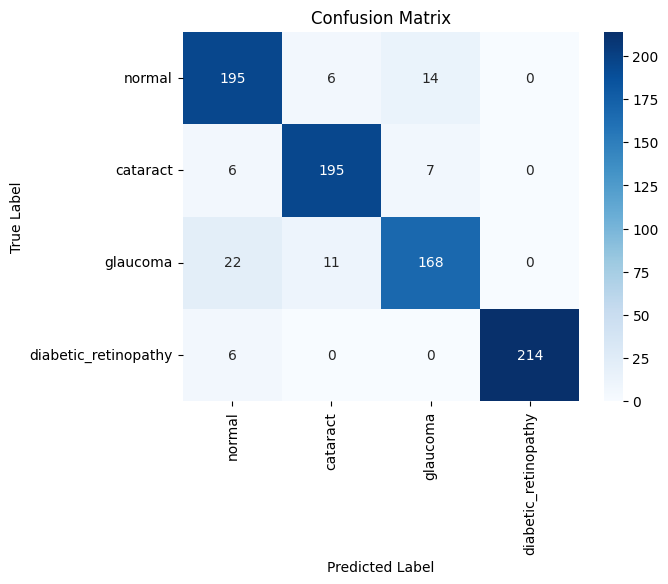

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred) # Menghitung Confusion Matrix yang menunjukan jumlah predisi yang benar dan salah untuk setiap kategori
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix') # Menambahkan judul pada plot
plt.ylabel('True Label') # Menambahkan label pada sumbu y
plt.xlabel('Predicted Label') # Menambahkan label pada sumbu x
plt.show() # menampilkan plot

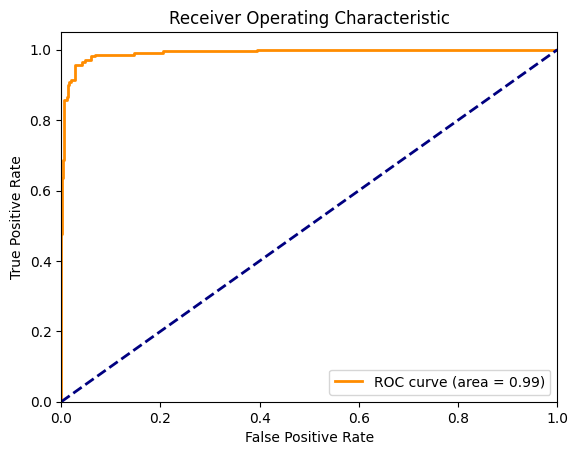

In [ ]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, ensemble.predict_proba(X_test_pca)[:, 1], pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()